# 1. Keras 텍스트 전처리
    1. [수치 데이터로 변환] 텍스트 토큰화 및 정수 인코딩
    2. [같은 길이로 만들기] 패딩 (padding)

In [1]:
# tensorflow 설치 확인
import tensorflow
tensorflow.__version__

'2.10.0'

In [3]:
# 연습 샘플
texts = [
    "나는 학교에 간다",
    "너는 도서관에 간다",
    "그는 시장에 간다"
]
#texts = [ ["나", "학교", "가"], ["너", "도서관", "가"], ["그", "시장", "가"]]

## 1-1. 텍스트 데이터 Integer Encoding
- num_words = 사용할 단어 수 + 1

In [6]:
# Tokenizer 객체 생성 (특징 벡터용 단어 수와 OOV 토큰 지정)
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5, oov_token="<OOV>")

# 특징 집합 생성 및 정수 indexing
tokenizer.fit_on_texts(texts) #fit
print("단어 사전 : ", tokenizer.word_index)

# 입력 텍스트 리스트의 integer encoding
encoded_texts = tokenizer.texts_to_sequences(texts) #transform
print("정수 인코딩 결과 : ", encoded_texts)

단어 사전 :  {'<OOV>': 1, '간다': 2, '나는': 3, '학교에': 4, '너는': 5, '도서관에': 6, '그는': 7, '시장에': 8}
정수 인코딩 결과 :  [[3, 4, 2], [1, 1, 2], [1, 1, 2]]


## 1-2. Padding : 입력 시퀀스의 길이를 동일하게 조정하기

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequences = pad_sequences(encoded_texts, maxlen=2, padding='post', truncating='post')
print("패딩된 시퀀스 : ")
print(padded_sequences)

패딩된 시퀀스 : 
[[3 4]
 [1 1]
 [1 1]]


## 1-3. 정답 데이터 One-hot Encoding

In [12]:
label = [1, 0, 2, 5, 0, 2, 3]
from tensorflow.keras.utils import to_categorical

encoded_label = to_categorical(label)
encoded_label

array([[0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

# 2. 텍스트 전처리를 위한 파라미터 결정하기
- Integer Encoding을 위한 단어(특징) 집합의 크기 정하기 (Tokenizer의 num_words)
- Padding을 위한 시퀀스 길이 정하기 (pad_sequences의 max_len) 

In [15]:
# 데이터 로딩 및 실습 데이터 추출
import pandas as pd
texts = list(pd.read_csv('./data/Korean_movie_reviews_2016.csv').review)
texts[:2]

['부산 행 때문 너무 기대하고 봤', '한국 좀비 영화 어색하지 않게 만들어졌 놀랍']

## 2-1. 단어 집합의 크기 정하기 (Tokenizer의 num_words)
등장 빈도수가 기준값(threshold)보다 적은 단어의 비중을 확인하여 정하기
1. corpus의 전체 단어 수 (total_cnt)와 전체 빈도수 (total_freq) 계산
2. threshold보다 빈도수가 적은 단어수 카운트 (rare_cnt)와 빈도수 (rare_freq) 계산
3. 희귀 단어의 비율(rare_cnt/total_cnt)과 희귀 등장 빈도 비율 계산(rare_freq/total_freq)
4. 희귀 단어를 뺀 단어 수 -> 단어 집합의 크기 산정

In [18]:
# Tokenizer로 단어-빈도 사전 생성
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
len(tokenizer.word_index)

52011

In [19]:
# 등장 빈도수가 threshold회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 3
total_cnt = len(tokenizer.word_index)
total_freq = 0
rare_cnt = 0
rare_freq = 0

for word, freq in tokenizer.word_counts.items():
    total_freq += freq

    if (freq < threshold):
        rare_cnt += 1
        rare_freq += freq

print(f'전체 단어 : {total_cnt:,}개 {total_freq:,}번')
print(f'희귀 단어 : {rare_cnt:,}개 {rare_freq:,}번')
print(f'희귀 단어 비율 : {(rare_cnt/total_cnt) * 100:.2f}%')
print(f'희귀 단어 빈도 비율 : {(rare_freq/total_freq) * 100:.2f}%')
print(f'희귀 단어를 뺀 단어 수 : {total_cnt - rare_cnt:,}개')

전체 단어 : 52,011개 1,888,659번
희귀 단어 : 29,364개 35,871번
희귀 단어 비율 : 56.46%
희귀 단어 빈도 비율 : 1.90%
희귀 단어를 뺀 단어 수 : 22,647개


## 2-2. Padding 길이 정하기 (pad_sequences의 max_len)
1. 단어 길이 데이터로 DataFrame 생성
2. 분포 시각화 : DataFrame의 Histogram 시각화 (df.hist())
3. 단어 길이 통계 정보 확인 (df.describe())
4. 텍스트의 길이가 설정한 max_len 이하인 비율 계산

In [21]:
#단어 길이 데이터로 DataFrame 생성
import pandas as pd

# 단어 길이 리스트 생성
len_list = [len(text.split()) for text in texts]
# len_list = [len(text.split()) for text in texts[:5]]

# 단어 길이 DataFrame 생성
len_df = pd.DataFrame(len_list, columns=['length'])
len_df.head()

,length
0,6
1,7
2,10
3,31
4,19


array([[<Axes: title={'center': 'length'}>]], dtype=object)

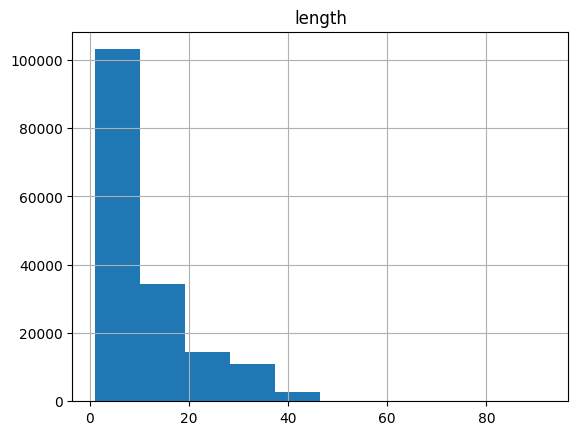

In [22]:
# 분포 시각화 : DataFrame의 Histogram 시각화 (df.hist())
len_df.hist()

In [23]:
#단어 길이 통계 정보 확인 (df.describe())
len_df.describe()

,length
count,165384.000000
mean,11.419841
std,9.117849
min,1.000000
25%,5.000000
50%,8.000000
75%,15.000000
max,92.000000


In [24]:
#텍스트의 길이가 설정한 max_len 이하인 비율 계산
max_len = 40
count = 0 # max_len 이하인 문장의 수

for length in len_list:
    if (length <= max_len):
        count += 1

print(f'길이가 {max_len} 이하인 데이터 비율 : {(count / len(len_list)) * 100:.2f}%')

길이가 40 이하인 데이터 비율 : 99.58%
